The goal of this project is to develop a model that can accurately predict the median house value in California based on various features.

# Getting data

In [ ]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

# Getting know to the data

In [ ]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


**Save figure fucntion**

In [ ]:
IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

**Plot the data on histogram chart**

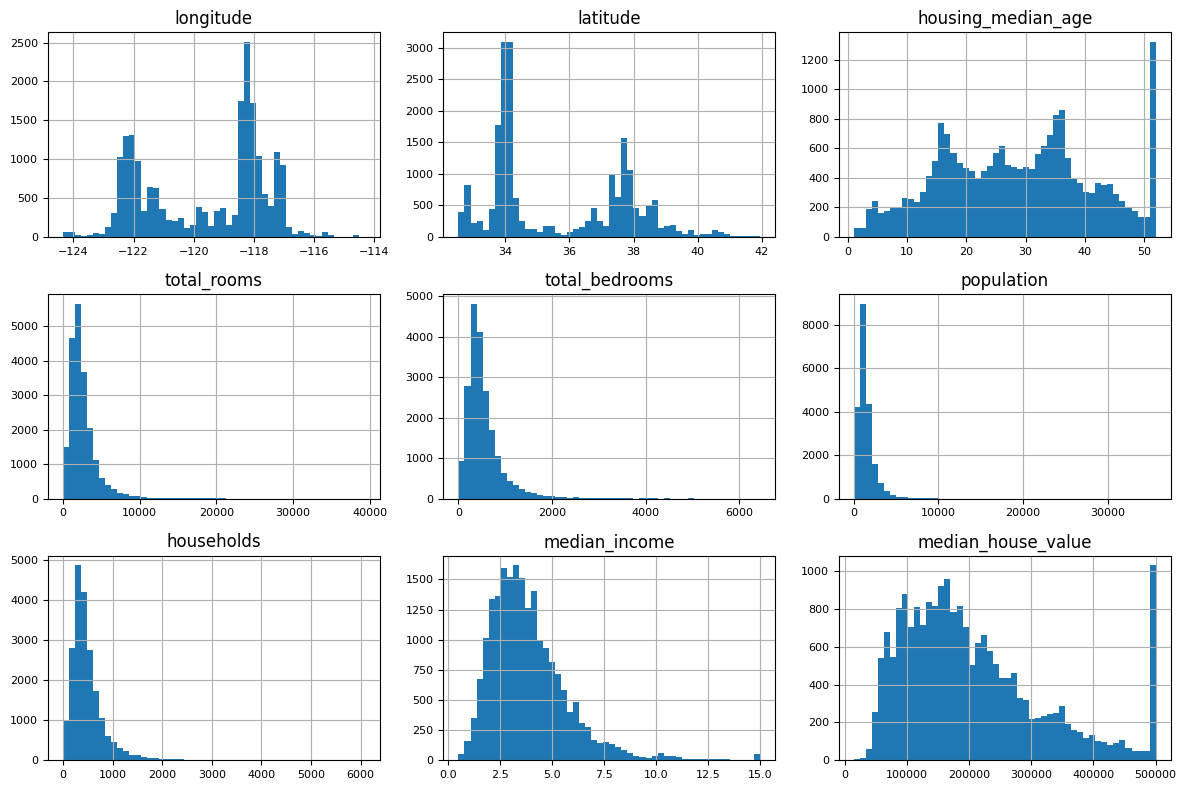

In [ ]:
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(12, 8), xlabelsize=8, ylabelsize=8)
save_fig("attribue_histogram_plot")
plt.show()

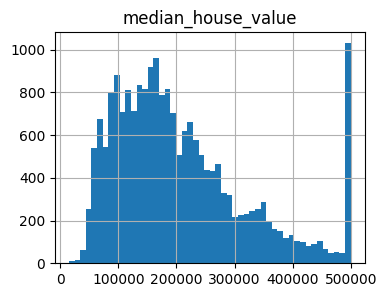

In [ ]:
housing.hist(column="median_house_value", bins=50, figsize=(4, 3), xlabelsize=10, ylabelsize=10)
plt.show()

Copy the desiered picture to my directiory

In [ ]:
!cp -r /content/images /content/drive/MyDrive

cp: cannot create directory '/content/drive/MyDrive': No such file or directory


# Train set and test set

In [ ]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[test_indices], data.iloc[train_indices]

test_set, train_set = shuffle_and_split_data(housing, .2)

In [ ]:
np.random.seed(42)
np.random.permutation(len(housing))

array([20046,  3024, 15663, ...,  5390,   860, 15795])

**Main**

In [ ]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
  return crc32(np.int64(identifier)) < test_ratio * 2 ** 32

def split_data_with_id_hash(data, test_ratio, id_column):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
  return data.loc[~in_test_set], data.loc[in_test_set]

In [ ]:
housing_with_id = housing.reset_index()
train_set, test_set = split_data_with_id_hash(housing_with_id, .2, 'index')

**An another way**

In [ ]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

**Using sklearn function**

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=.2, random_state=42)

**Using stratified data in order to the cover data better than choosing randomly**

In [ ]:
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0.0, 1.5, 3, 4.5, 6, np.inf],
                               labels=[1, 2, 3, 4, 5])

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=.2, random_state=42)
strat_splits = list()
for train_index, test_index in splitter.split(housing, housing['income_cat']):
  strat_train_set_n = housing.iloc[train_index]
  strat_test_set_n = housing.iloc[test_index]
  strat_splits.append([strat_train_set_n, strat_test_set_n])

In [ ]:
strat_train_set, strat_test_set = strat_splits[0]

**Much** **shorter**

In [ ]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=.2, stratify=housing['income_cat'],
                                                   random_state=42)

In [ ]:
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY,2
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN,5
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND,2
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND,2
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN,3


Drop income category

In [ ]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Discover and visualize the data

In [ ]:
housing = strat_train_set.copy()

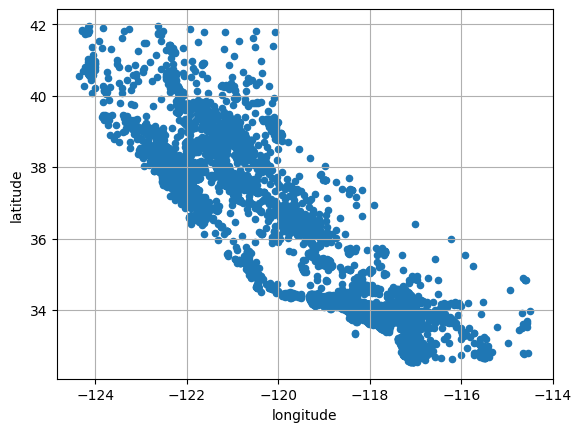

In [ ]:
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True)
plt.show()

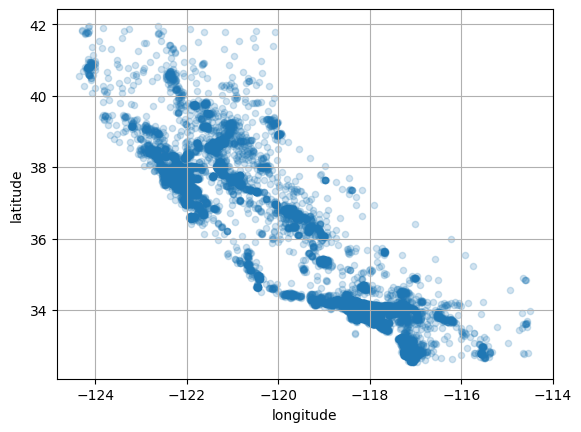

In [ ]:
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True, alpha=.2)
plt.show()

<Axes: xlabel='longitude', ylabel='latitude'>

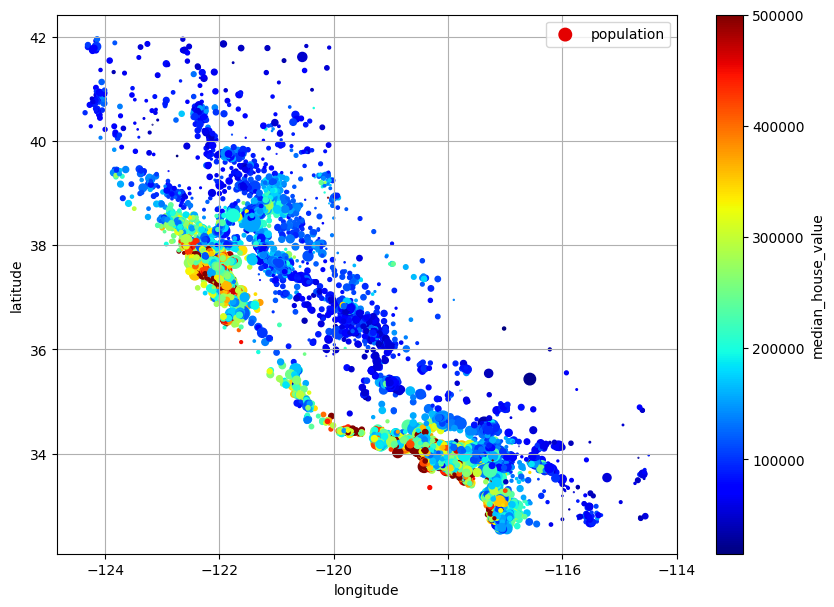

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

In [ ]:
IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

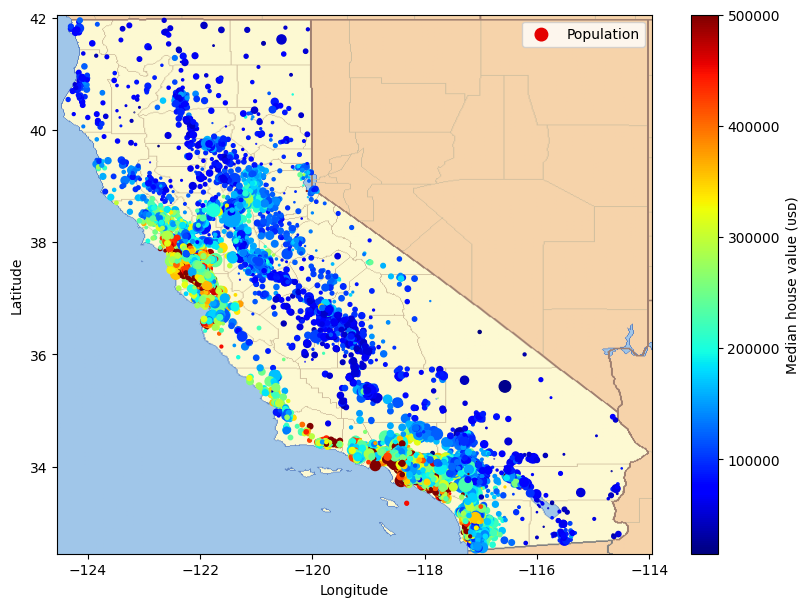

In [ ]:
filename = "california.png"
if not (IMAGES_PATH / filename).is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + "images/end_to_end_project/" + filename
    print("Downloading", filename)
    urllib.request.urlretrieve(url, IMAGES_PATH / filename)

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed.plot(
             kind="scatter", x="Longitude", y="Latitude",
             s=housing_renamed["Population"] / 100, label="Population",
             c="Median house value (ᴜsᴅ)", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

california_img = plt.imread(IMAGES_PATH / filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)

plt.show()

## Correlation

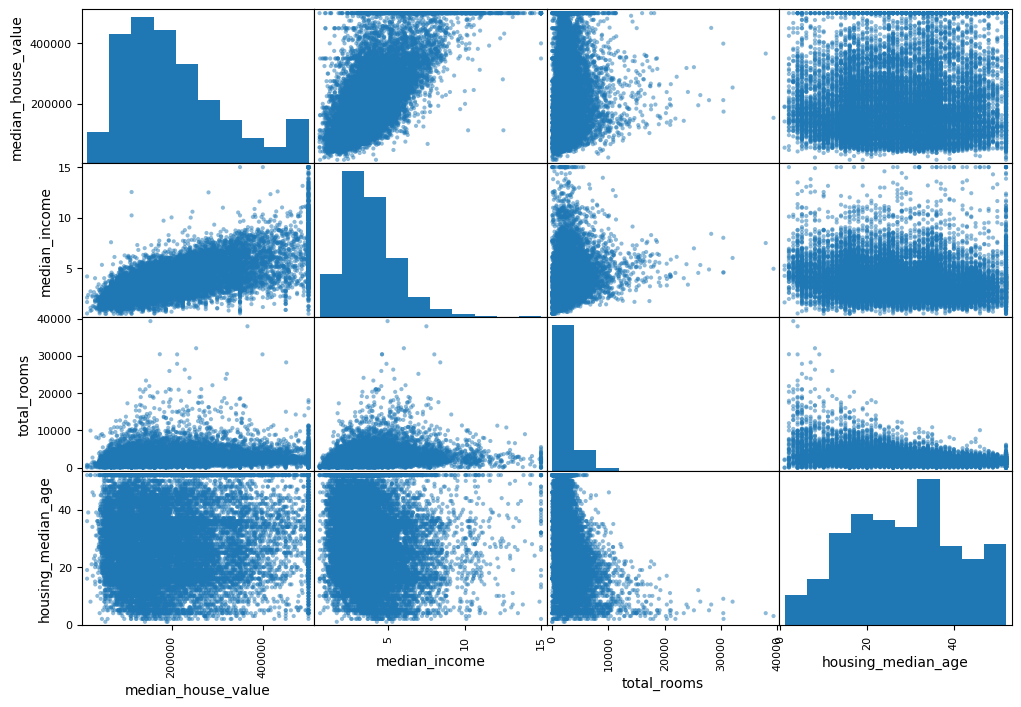

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms',
              'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

# Data prepration

In [ ]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

## Clean the data

In [ ]:
null_row_inx = housing.isnull().any(axis=1)
housing.loc[null_row_inx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


**Option 1. Get rid of the corresponding districts**

In [ ]:
housing_option1 = housing.copy()
housing_option1.dropna(subset=['total_bedrooms'], inplace=True)
housing_option1.loc[null_row_inx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


**Option 2.  Get rid of the whole attribute**

In [ ]:
housing_option2 = housing.copy()
housing_option2.drop('total_bedrooms', inplace=True, axis=1)
housing_option2.loc[null_row_inx].head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,375.0,183.0,9.8020,<1H OCEAN


Option 3. Imputation

In [ ]:
housing_option3 = housing.copy()
median = housing['total_bedrooms'].median()
housing_option3['total_bedrooms'].fillna(median, inplace=True)

housing_option3.loc[null_row_inx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,<1H OCEAN


Using sklearn for imputing

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

seperating numerical atributes

In [ ]:
housing_num = housing.select_dtypes(include=[np.number])
housing_num.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292


In [ ]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [ ]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [ ]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

Transform

In [ ]:
X = imputer.transform(housing_num)

In [ ]:
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [ ]:
housing_tr.loc[null_row_inx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


# Drop some outliers

In [ ]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest()
outlier_pred = isolation_forest.fit_predict(X)
outlier_pred

array([-1,  1,  1, ...,  1,  1,  1])

In [ ]:
df = pd.DataFrame(outlier_pred, index=housing_num.index)

In [ ]:
#housing = housing.iloc[outlier_pred == 1]
#housing_labels = housing_labels.iloc[outlier_pred == 1]

In [ ]:
#plt.scatter(x=housing['median_income'], y=housing_labels)

# Handling text and categorical attributes

In [ ]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [ ]:
housing_cat['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     7274
INLAND        5301
NEAR OCEAN    2089
NEAR BAY      1846
ISLAND           2
Name: count, dtype: int64

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [ ]:
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [ ]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [ ]:
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [ ]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [ ]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
df_test

,ocean_proximity
0,INLAND
1,NEAR BAY


In [ ]:
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [ ]:
cat_encoder.transform(df_test).toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [ ]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [ ]:
#cat_encoder.transform(df_test_unknown)
#raise an error

In [ ]:
cat_encoder.handle_unknown = 'ignore'
cat_encoder.transform(df_test_unknown).toarray()

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [ ]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [ ]:
housing_cat

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
...,...
14207,<1H OCEAN
13105,INLAND
19301,NEAR OCEAN
19121,<1H OCEAN


# I DO

In [ ]:
ocean_prox_encoded = pd.DataFrame(housing_cat_1hot.toarray(),
             columns=cat_encoder.get_feature_names_out(),
             index=housing_cat.index)
ocean_prox_encoded.head(8)

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
13096,0.0,0.0,0.0,1.0,0.0
14973,1.0,0.0,0.0,0.0,0.0
3785,0.0,1.0,0.0,0.0,0.0
14689,0.0,1.0,0.0,0.0,0.0
20507,0.0,0.0,0.0,0.0,1.0
1286,0.0,1.0,0.0,0.0,0.0
18078,1.0,0.0,0.0,0.0,0.0
4396,0.0,0.0,0.0,1.0,0.0


In [ ]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292


In [ ]:
ready_housing = pd.concat([housing_tr, ocean_prox_encoded], axis=1)
ready_housing.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,0.0,0.0,0.0,1.0,0.0
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,1.0,0.0,0.0,0.0,0.0
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,0.0,1.0,0.0,0.0,0.0
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,0.0,1.0,0.0,0.0,0.0
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,0.0,0.0,0.0,0.0,1.0
1286,-121.31,37.96,52.0,1829.0,301.0,694.0,319.0,3.3466,0.0,1.0,0.0,0.0,0.0
18078,-118.36,33.85,34.0,1086.0,197.0,509.0,158.0,6.1133,1.0,0.0,0.0,0.0,0.0
4396,-122.13,37.41,36.0,4787.0,900.0,2039.0,890.0,5.4063,0.0,0.0,0.0,1.0,0.0
18031,-118.44,34.31,22.0,3182.0,822.0,2661.0,746.0,2.7472,1.0,0.0,0.0,0.0,0.0
6753,-118.13,34.06,17.0,1714.0,572.0,1590.0,568.0,1.1875,1.0,0.0,0.0,0.0,0.0


# Feature scaling

Min Max scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)
housing_num_min_max_scaled = pd.DataFrame(housing_num_min_max_scaled,
                                          columns=housing_num.columns,
                                          index=housing_num.index)
housing_num_min_max_scaled.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-0.608519,0.117021,1.000000,-0.831171,-0.641166,-0.807018,-0.614336,-0.779479
14973,0.210953,-0.661702,0.529412,-0.900148,-0.886294,-0.918660,-0.867090,-0.229293
3785,-0.519270,0.236170,0.254902,-0.945012,-0.930424,-0.931419,-0.924585,-0.733369
14689,0.468560,-0.744681,-0.372549,-0.787782,-0.726204,-0.774015,-0.709166,-0.756983
20507,0.257606,-0.740426,0.372549,-0.778015,-0.610243,-0.765796,-0.562815,-0.582171


Standardization

In [ ]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_std_scaled = std_scaler.fit_transform(housing_num)
housing_std_scaled = pd.DataFrame(housing_std_scaled,
                                  columns=housing_num.columns,
                                  index=housing_num.index)
housing_std_scaled.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.359094,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.436356,-0.693771,-0.373485,1.171942
3785,-1.203098,1.276119,0.351428,-0.712240,-0.759584,-0.788768,-0.775727,-0.759789
14689,1.231216,-0.884924,-0.919891,0.702262,0.736231,0.383175,0.731375,-0.850281
20507,0.711362,-0.875549,0.589800,0.790125,1.585590,0.444376,1.755263,-0.180365


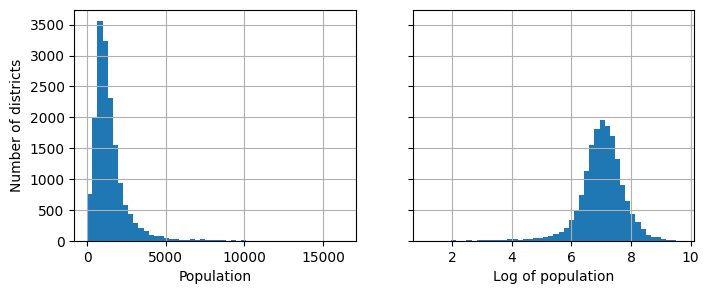

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
plt.show()

<Axes: >

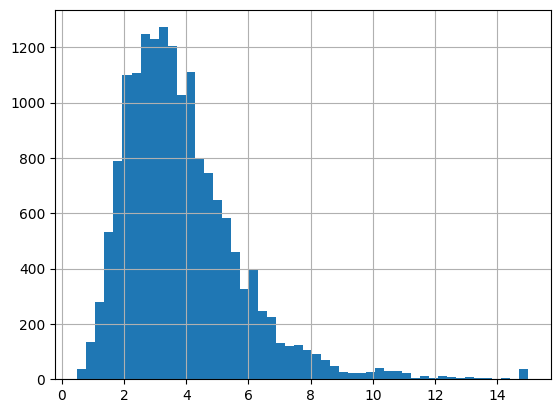

In [ ]:
housing["median_income"].hist(bins=50)

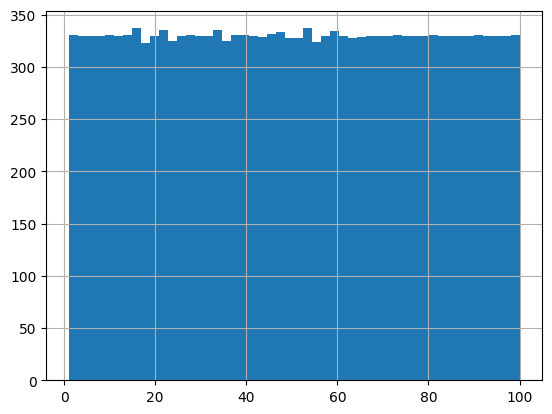

In [ ]:
import numpy as np

percentiles = [np.percentile(housing["median_income"], p) for p in range(1, 100)]
flattened_median_income = pd.cut(housing["median_income"],
                                 bins=[-np.inf] + percentiles + [np.inf],
                                 labels=range(1, 100 + 1))
flattened_median_income.hist(bins=50)
plt.show()

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], Y=[[35]], gamma=0.1)

## ***Custom Transformers***

# don’t require any training

In [ ]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

In [ ]:
rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.fit_transform(housing[['housing_median_age']])

an array with two features

In [ ]:
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

combine features

In [ ]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

## trainable transformer

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though we don't use it
        X = check_array(X)  # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

In [ ]:
standard_scaler_c = StandardScalerClone()
standard_scaler_c.fit(housing_option3.drop('ocean_proximity', axis=1))

StandardScalerClone()

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, n_init=10, random_state=42)
kmeans.fit(housing[['latitude', 'longitude']], sample_weight=housing_labels)
kmeans.cluster_centers_

array([[  33.84807612, -117.76264178],
       [  37.79339173, -121.02020116],
       [  34.05401714, -118.32417903],
       [  36.64651014, -119.5667933 ],
       [  40.22071398, -123.06364765],
       [  38.86476363, -121.2349362 ],
       [  32.93618777, -117.03359137],
       [  37.88199464, -122.33783088],
       [  34.69806089, -119.75396145],
       [  37.26057373, -121.95821379]])

In [ ]:
rbf_kernel(housing[['latitude', 'longitude']], kmeans.cluster_centers_, gamma=.1)[: 5].round(2)

array([[0.02, 0.82, 0.05, 0.39, 0.53, 0.78, 0.01, 1.  , 0.19, 0.95],
       [0.95, 0.13, 1.  , 0.46, 0.  , 0.05, 0.72, 0.05, 0.8 , 0.1 ],
       [0.02, 0.88, 0.04, 0.42, 0.63, 0.92, 0.  , 0.96, 0.16, 0.89],
       [0.96, 0.04, 0.85, 0.24, 0.  , 0.01, 0.94, 0.01, 0.45, 0.03],
       [0.98, 0.09, 0.99, 0.36, 0.  , 0.03, 0.82, 0.03, 0.71, 0.07]])

In [ ]:
housing.head(1)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
13096,-122.42,37.8,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,NEAR BAY


In [ ]:
housing_labels.head(1)

13096    458300.0
Name: median_house_value, dtype: float64

In [ ]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [ ]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)

# Pipeline

In [ ]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ('impute', SimpleImputer()),
    ('standardscaler', StandardScaler())
])
num_pipeline

Pipeline(steps=[('impute', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [ ]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[: 2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [ ]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index
)
df_housing_num_prepared.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.366061,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.438593,-0.693771,-0.373485,1.171942


In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('simpleimputer_num', SimpleImputer(strategy='median')),
    ('standardscaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('simpleimputer_cat', SimpleImputer(strategy='most_frequent')),
    ('onehotencoder', OneHotEncoder())
])

preprocessing = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])

In [ ]:
pd.DataFrame(preprocessing.fit_transform(housing),
             columns=preprocessing.get_feature_names_out(),
             index=housing.index
).head()

,num__longitude,num__latitude,num__housing_median_age,num__total_rooms,num__total_bedrooms,num__population,num__households,num__median_income,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,1.0,0.0,0.0,0.0,0.0
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789,0.0,1.0,0.0,0.0,0.0
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281,0.0,1.0,0.0,0.0,0.0
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365,0.0,0.0,0.0,0.0,1.0


In [ ]:
def column_ratio(X):
  return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_name_in):
  return ['ratio']

def ratio_pipeline():
  return Pipeline([
      ('simpleimputer', SimpleImputer(strategy='median')),
      ('ratio', FunctionTransformer(column_ratio, feature_names_out=ratio_name)),
      ('standardscaler', StandardScaler())
  ])

log_pipeline = Pipeline([
    ('simpleimputer', SimpleImputer(strategy='median')),
    ('log', FunctionTransformer(np.log, feature_names_out="one-to-one")),
    ('standardscaler', StandardScaler())
])

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)

cat_pipeline = Pipeline([
    ('simpleimputer_cat', SimpleImputer(strategy='most_frequent')),
    ('onehotencoder', OneHotEncoder())
])

default_num_pipeline = Pipeline([
    ('simpleimputer', SimpleImputer(strategy='median')),
    ('standardscaler', StandardScaler())
])

preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, ['ocean_proximity']),
    ],
    remainder=default_num_pipeline)

In [ ]:
housing_prepared = preprocessing.fit_transform(housing)
pd.DataFrame(housing_prepared,
             columns=preprocessing.get_feature_names_out(),
             index=housing.index).head()

,bedrooms__ratio,rooms_per_house__ratio,people_per_house__ratio,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,geo__Cluster 0 similarity,geo__Cluster 1 similarity,...,geo__Cluster 6 similarity,geo__Cluster 7 similarity,geo__Cluster 8 similarity,geo__Cluster 9 similarity,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN,remainder__housing_median_age
13096,1.846624,-0.866027,-0.330204,1.324114,0.637892,0.456906,1.310369,-1.071522,3.788947e-18,1.319640e-01,...,3.398866e-24,9.698809e-01,7.073518e-08,5.824761e-01,0.0,0.0,0.0,1.0,0.0,1.861119
14973,-0.508121,0.024550,-0.253616,-0.252671,-0.063576,-0.711654,-0.142030,1.194712,3.346712e-01,1.735776e-09,...,2.706351e-02,8.786936e-14,1.275435e-01,2.078829e-10,1.0,0.0,0.0,0.0,0.0,0.907630
3785,-0.202155,-0.041193,-0.051041,-0.925266,-0.859927,-0.941997,-0.913030,-0.756981,2.874903e-18,2.749482e-01,...,1.020912e-24,7.483836e-01,1.871204e-08,2.896858e-01,0.0,1.0,0.0,0.0,0.0,0.351428
14689,-0.149006,-0.034858,-0.141475,0.952773,0.943475,0.670700,0.925373,-0.912253,8.832834e-01,2.237307e-14,...,4.613653e-01,3.428945e-20,5.336846e-04,3.778950e-16,0.0,1.0,0.0,0.0,0.0,-0.919891
20507,0.963208,-0.666554,-0.306148,1.437622,1.003590,0.719093,1.481464,0.034537,4.893551e-01,2.891966e-11,...,1.092264e-01,7.073121e-16,3.490774e-02,3.361020e-12,0.0,0.0,0.0,0.0,1.0,0.589800


# Train the model

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = Pipeline([
    ('preprocessing', preprocessing),
    ('linearregression', LinearRegression())
])
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ratio',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7eddac0195a0>,
                                                                                       func=<f...
                                                                   StandardScaler())]),
                                                  ['total_bedrooms',
                                                   'total_rooms', 'population',
                                                   'households',
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['ocean_proximity'])])),
                ('linearregression', LinearRegression())])

In [ ]:
housing_prediction = lin_reg.predict(housing)
housing_prediction[: 5].round(-2)

array([243700., 372400., 128800.,  94400., 328300.])

In [ ]:
housing_labels.iloc[: 5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [ ]:
housing_prediction[: 5].round(-2) / housing_labels.iloc[: 5].values - 1

array([-0.46825224, -0.23026044,  0.26647001, -0.01768991, -0.09259259])

In [ ]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_labels, housing_prediction,
                              squared=False)
lin_rmse

68687.89176590038

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = Pipeline([
    ('preprocessing', preprocessing),
    ('decisiontreeregressor', DecisionTreeRegressor(random_state=42))
])
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ratio',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7eddac0195a0>,
                                                                                       func=<f...
                                                  ['total_bedrooms',
                                                   'total_rooms', 'population',
                                                   'households',
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['ocean_proximity'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [ ]:
housing_prediction = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_prediction, housing_labels,
                               squared=False)
tree_rmse

0.0

# Better Evaluation

In [ ]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
tree_rmses

array([66506.70121103, 67097.20497743, 66144.65155743, 65069.22056897,
       64727.51994473, 70094.77824639, 67685.73110573, 68411.33556978,
       69293.5932016 , 63649.53649274])

In [ ]:
lin_rmses = -cross_val_score(lin_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
lin_rmses

array([69622.70610202, 68430.98941679, 65397.78014434, 80959.34817064,
       68404.66200635, 68808.48626722, 67959.16101583, 71174.39015859,
       67950.12558365, 69872.53308807])

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = Pipeline([
    ('preprocessing', preprocessing),
    ('randomforestregressor', RandomForestRegressor(random_state=42))
])
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=10)
forest_rmses

array([46336.33927043, 47340.03146064, 45458.11252725, 46847.10692372,
       46004.08554711, 46955.59525055, 46979.59745817, 49243.76579537,
       47748.29301325, 47282.68556492])

# Fine tune your model

In [ ]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('randomforestregressor', RandomForestRegressor(random_state=42))
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'randomforestregressor__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'randomforestregressor__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ratio',
                                                                                          FunctionTransformer(feature_names_out=<function ratio_n...
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder())]),
                                                                         ['ocean_proximity'])])),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'randomforestregressor__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'randomforestregressor__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'randomforestregressor__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('ratio',
                                                                                                FunctionTransformer(feature_names_out=<function r...
                                             ('randomforestregressor',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7eddabda8490>,
                                        'randomforestregressor__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7eddabda8cd0>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [ ]:
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_randomforestregressor__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]

score_cols = ["split0", "split1", "split2", "mean_test_rmse"]

cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
1,45,9,41287,42071,42627,41995
8,32,7,41690,42513,43224,42475
0,41,16,42223,42959,43321,42834
5,42,4,41818,43094,43817,42910
2,23,8,42264,42996,43830,43030


In [ ]:
final_model = rnd_search.best_estimator_
feature_importances = final_model['randomforestregressor'].feature_importances_
feature_importances.round(2)

array([0.07, 0.05, 0.05, 0.01, 0.01, 0.01, 0.01, 0.19, 0.04, 0.01, 0.  ,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.01, 0.  , 0.01,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.  , 0.02, 0.01, 0.01, 0.01, 0.02,
       0.01, 0.  , 0.02, 0.03, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01,
       0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.  , 0.07,
       0.  , 0.  , 0.  , 0.01])

In [ ]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

[(0.18694559869103852, 'log__median_income'),
 (0.0748194905715524, 'cat__ocean_proximity_INLAND'),
 (0.06926417748515576, 'bedrooms__ratio'),
 (0.05446998753775219, 'rooms_per_house__ratio'),
 (0.05262301809680712, 'people_per_house__ratio'),
 (0.03819415873915732, 'geo__Cluster 0 similarity'),
 (0.02879263999929514, 'geo__Cluster 28 similarity'),
 (0.023530192521380392, 'geo__Cluster 24 similarity'),
 (0.020544786346378206, 'geo__Cluster 27 similarity'),
 (0.019873052631077512, 'geo__Cluster 43 similarity'),
 (0.018597511022930273, 'geo__Cluster 34 similarity'),
 (0.017409085415656868, 'geo__Cluster 37 similarity'),
 (0.015546519677632162, 'geo__Cluster 20 similarity'),
 (0.014230331127504292, 'geo__Cluster 17 similarity'),
 (0.0141032216204026, 'geo__Cluster 39 similarity'),
 (0.014065768027447325, 'geo__Cluster 9 similarity'),
 (0.01354220782825315, 'geo__Cluster 4 similarity'),
 (0.01348963625822907, 'geo__Cluster 3 similarity'),
 (0.01338319626383868, 'geo__Cluster 38 similarity'

In [ ]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

41424.40026462184


# Saving model

In [ ]:
import joblib

path = '/content/drive/My Drive/Hands on ML/chap.2/Model/my_california_housing_model.pkl'
final_model_reloaded = joblib.dump(final_model, path)